# Temporal difference control on GridWorld game: cliff walking

http://incompleteideas.net/book/bookdraft2017nov5.pdf

### Implement SARSA/Q-learning

<IPython.core.display.Javascript object>


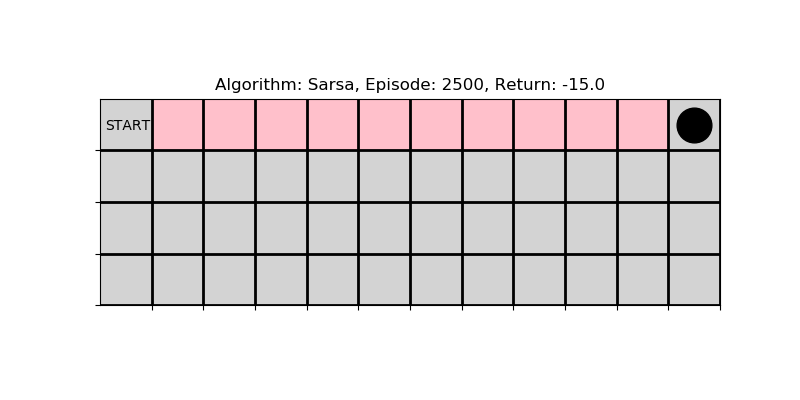

Convergence in 2878 episodes


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from aux import plotGrid, moveAgent, selectAction, progress, updateOnline, selectEpisode, plotAgent, GridMap

mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib notebook

# Algorithm to employ
mode    = 'Sarsa'

# Initialise grid map object and plot empty grid
GridWorld = GridMap(12,4)
[fig, ax] = plotGrid(GridWorld)

# Create list of actions
actions = np.array(['UP', 'RIGHT', 'DOWN', 'LEFT'])

# Initialise Q function, learning rate
Q       = np.zeros([4, GridWorld.h, GridWorld.w])
alpha   = 0.1
factor  = 0.999
plotInt = 500
maxIter = 10000
eps     = 0.1
sleep   = 0.05
conv    = []
 
# Execute SARSA control algorithm

for episode in range(maxIter):

    # initialise agent position, plot initial position
    agentPos = GridWorld.start
    
    # Determine whether this episode should be plotted
    plotThisEp = selectEpisode(plotInt, episode)
    
    # Plot every fixed number of episodes
    if plotThisEp: plotAgent(ax, fig, agentPos)

    # Initialise step, return
    t       = 0
    return_ = 0
    prevState = GridWorld.start
    
    alpha = alpha*1
    eps   = eps*factor
    prevQ = Q.copy()
    
    while prevState != GridWorld.end:
        
        # Select action for behaviour, move agent according to selected action
        [action, nextAgPos, Rwd, aIdx] = progress(Q, actions, eps, agentPos, GridWorld)
        return_ += Rwd
        
        # Backup
        if t > 0:    
            Q = updateOnline(Q, prevAIdx, prevState, alpha, prevRwd, aIdx, agentPos,mode)
        
        # Logical value, true if agent fell off the cliff
        cliffFlag = GridWorld.grid[nextAgPos[1], nextAgPos[0]] == GridWorld.cliffRwd

        # Refresh agent position on the plotted gridmap, update plot title
        if plotThisEp:
            plotAgent(ax, fig, nextAgPos, sleep=sleep) 
            plt.title("Algorithm: "+ mode + ", Episode: " + str(episode) + ", Return: " + str(return_))
        
        # if agent falls in a cliff cell, stop episode but update action value function
        if cliffFlag: 
            Q[aIdx, agentPos[1], agentPos[0]] = (1-alpha) * Q[aIdx, agentPos[1], agentPos[0]] + alpha*(Rwd+0)
            break

        # Store previous values for next update
        prevRwd       = Rwd
        prevState     = agentPos.copy()
        prevAIdx      = aIdx
        agentPos      = nextAgPos.copy()

        t += 1
    
    conv.append(np.amax(abs(Q - prevQ)))
    if len(conv) > 100 and sum(conv[-100:-1]) < 1: break
        
if episode < maxIter - 1:
    print("Convergence in "+str(episode)+" episodes")
else:
    print("Maximum number of iterations reached without convergence")

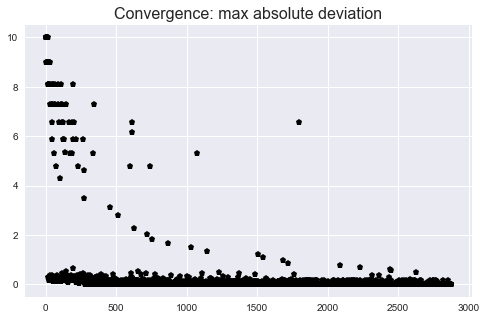

In [2]:
# Analyse convergence
%matplotlib inline
sns.set()
fig, ax = plt.subplots(figsize = (8,5))
plt.plot(conv, 'pk')
plt.title('Convergence: max absolute deviation', fontsize=16)
plt.show()

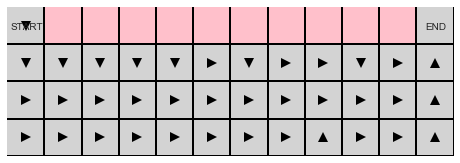

In [3]:
# Get array of best action from each state and plot arrows on the gridmap
maxA = Q.argmax(axis=0)
markerDict = {0:"k^", 1:"k>", 2:"kv", 3:"k<"}

%matplotlib inline
[fig, ax] = plotGrid(GridWorld)

for y in range(maxA.shape[0]):
    for x in range(maxA.shape[1]):
        if GridWorld.grid[y, x] != -100 and [x, y] != GridWorld.end:
            ax.plot(x, y, markerDict[maxA[y,x]], ms=10)
plt.show()

### Plot heatmap of action value function of each action

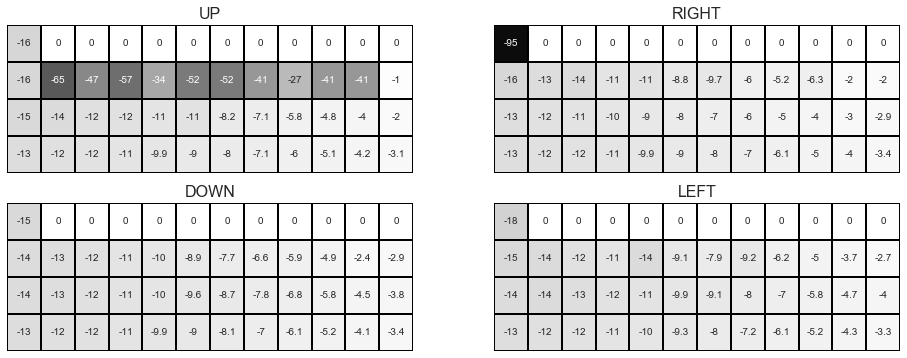

In [4]:
%matplotlib inline
fig, ax = plt.subplots(2,2, figsize = (16,6))

for i in range(2):
    for j in range(2):
        sns.heatmap(Q[2*i+j,:,:], ax=ax[i,j], vmax=0, vmin=-100, cbar=False, cmap='gray',
                    linewidths=1, annot=True, xticklabels=False, yticklabels=False,
                   linecolor='black')
        ax[i,j].set_title(actions[2*i+j], fontsize=16)    